# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

/tmp/ipykernel_12263/187924686.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  floor_plan = imageio.imread('./map/vivocity.png')
/tmp/ipykernel_12263/187924686.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grid_map_img = imageio.imread('./map/vivocity_freespace.png')


Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


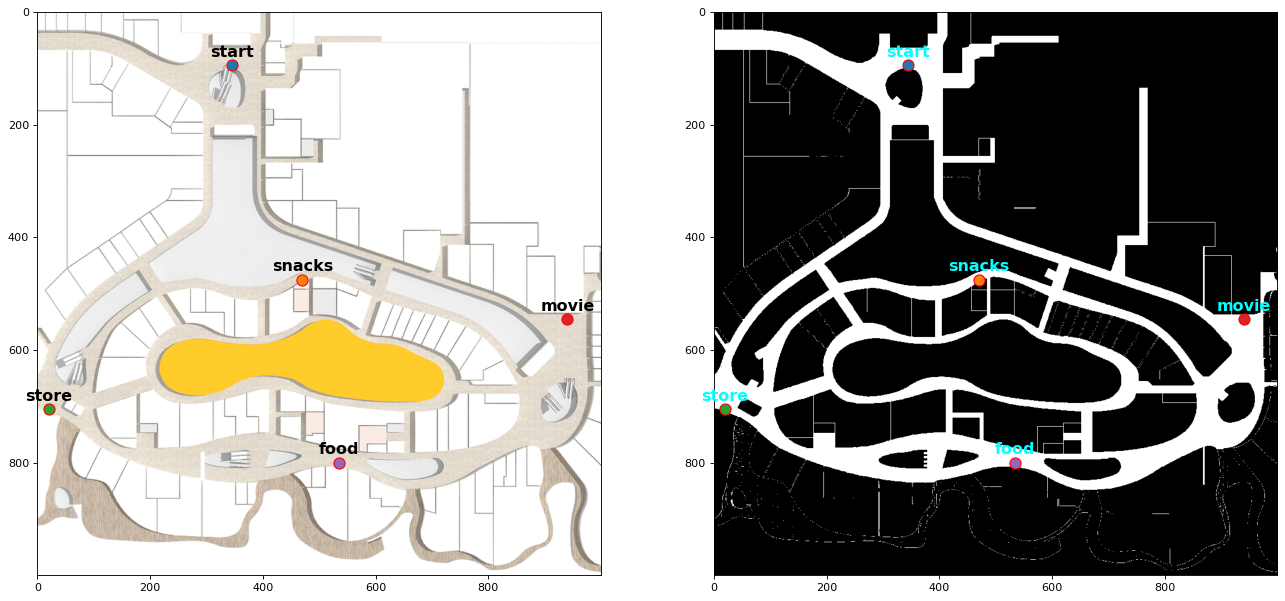

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [2]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1

In [3]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
import imageio

# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# Define a class for a node in the graph
class Node:
    def __init__(self, position, g_cost=float('inf'), h_cost=0, parent=None):
        self.position = tuple(position)  # Convert position to tuple
        self.g_cost = g_cost  # Cost from start node to this node
        self.h_cost = h_cost  # Heuristic cost from this node to the goal
        self.parent = parent  # Parent node in the path

    # Define comparison methods for priority queue
    def __lt__(self, other):
        return (self.g_cost + self.h_cost) < (other.g_cost + other.h_cost)

    def __eq__(self, other):
        return self.position == other.position

# Define heuristic function (Euclidean distance)
def heuristic(current, goal):
    dx = abs(current[0] - goal[0])
    dy = abs(current[1] - goal[1])
    diagonal = min(dx, dy)
    straight = dx + dy
    return 0.2 * 1.414 * diagonal + 0.2 * (straight - 2 * diagonal)

# Implement A* algorithm with 8-connected neighbors and different costs
def astar_search(grid, start, goal):
    open_list = []
    closed_set = set()

    start_node = Node(start, g_cost=0, h_cost=heuristic(start, goal))
    heapq.heappush(open_list, start_node)

    while open_list:
        current_node = heapq.heappop(open_list)

        if current_node.position == goal:
            path = []
            total_distance = current_node.g_cost
            while current_node:
                path.append(current_node.position)
                current_node = current_node.parent
            return path[::-1], total_distance

        closed_set.add(current_node.position)

        for next_pos in [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]:  # 8-connected neighbors
            new_position = (current_node.position[0] + next_pos[0], current_node.position[1] + next_pos[1])

            # Check if the new position is within the grid and not an obstacle
            if 0 <= new_position[0] < grid.shape[0] and 0 <= new_position[1] < grid.shape[1] and grid[new_position[0], new_position[1]] == 255:
                if new_position not in closed_set:
                    g_cost = current_node.g_cost + 0.2 * np.sqrt(next_pos[0]**2 + next_pos[1]**2)  # Adjusted cost for diagonal moves
                    h_cost = heuristic(new_position, goal)
                    new_node = Node(new_position, g_cost, h_cost, current_node)
                    heapq.heappush(open_list, new_node)
    return None, None  # No path found

# A helper function to mark the locations and path on the map
def plot_locations_and_path(locations: dict, path: list, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')

    if path:
        path_x = [pos[0] for pos in path]
        path_y = [pos[1] for pos in path]
        plt.plot(path_x, path_y, linestyle='-', color='blue', linewidth=2)

    return

# Define start and goal positions
start_position = locations['start']
goal_position = locations['food']

# Run A* algorithm
path, total_distance = astar_search(grid_map, start_position, goal_position)

# Plot the locations and path on the binary map
plt.figure(figsize=(10, 10))
plt.imshow(grid_map_img, cmap='gray')
plot_locations_and_path(locations, path)
plt.title('Path Visualization on Binary Map')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()



/tmp/ipykernel_12263/1934106801.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  floor_plan = imageio.imread('./map/vivocity.png')
/tmp/ipykernel_12263/1934106801.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grid_map_img = imageio.imread('./map/vivocity_freespace.png')


Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


: 

In [4]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
import imageio

# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# Define a class for a node in the graph
class Node:
    def __init__(self, position, g_cost=float('inf'), h_cost=0, parent=None):
        self.position = tuple(position)  # Convert position to tuple
        self.g_cost = g_cost  # Cost from start node to this node
        self.h_cost = h_cost  # Heuristic cost from this node to the goal
        self.parent = parent  # Parent node in the path

    # Define comparison methods for priority queue
    def __lt__(self, other):
        return (self.g_cost + self.h_cost) < (other.g_cost + other.h_cost)

    def __eq__(self, other):
        return self.position == other.position

# Define heuristic function (Euclidean distance)
def heuristic(current, goal):
    dx = abs(current[0] - goal[0])
    dy = abs(current[1] - goal[1])
    diagonal = min(dx, dy)
    straight = dx + dy
    return 0.2 * 1.414 * diagonal + 0.2 * (straight - 2 * diagonal)

# Implement A* algorithm with 8-connected neighbors and different costs
def astar_search(grid, start, goal, robot_radius):
    open_list = []
    closed_set = set()

    start_node = Node(start, g_cost=0, h_cost=heuristic(start, goal))
    heapq.heappush(open_list, start_node)

    while open_list:
        current_node = heapq.heappop(open_list)

        if current_node.position == goal:
            path = []
            total_distance = current_node.g_cost
            while current_node:
                path.append(current_node.position)
                current_node = current_node.parent
            return path[::-1], total_distance

        closed_set.add(current_node.position)

        for next_pos in [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]:  # 8-connected neighbors
            new_position = (current_node.position[0] + next_pos[0], current_node.position[1] + next_pos[1])

            # Check if the new position is within the grid and not an obstacle
            if 0 <= new_position[0] < grid.shape[0] and 0 <= new_position[1] < grid.shape[1] and grid[new_position[0], new_position[1]] == 255:
                if new_position not in closed_set:
                    # Adjust cost for diagonal moves and consider robot radius
                    if next_pos[0] != 0 and next_pos[1] != 0:
                        move_cost = 0.2 * 1.41
                    else:
                        move_cost = 0.2
                    g_cost = current_node.g_cost + move_cost
                    h_cost = heuristic(new_position, goal)
                    new_node = Node(new_position, g_cost, h_cost, current_node)
                    heapq.heappush(open_list, new_node)
    return None, None  # No path found

# A helper function to mark the locations and path on the map
def plot_locations_and_path(locations: dict, path: list, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')

    if path:
        path_x = [pos[0] for pos in path]
        path_y = [pos[1] for pos in path]
        plt.plot(path_x, path_y, linestyle='-', color='blue', linewidth=2)

    return

# Define start and goal positions
start_position = locations['start']
goal_position = locations['food']

# Robot radius
robot_radius = 0.3  # meters

# Run A* algorithm
path, total_distance = astar_search(grid_map, start_position, goal_position, robot_radius)

# Plot the locations and path on the binary map
plt.figure(figsize=(10, 10))
plt.imshow(grid_map_img, cmap='gray')
plot_locations_and_path(locations, path)
plt.title('Path Visualization on Binary Map')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()




/tmp/ipykernel_10516/2793292566.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  floor_plan = imageio.imread('./map/vivocity.png')
/tmp/ipykernel_10516/2793292566.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grid_map_img = imageio.imread('./map/vivocity_freespace.png')


Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


: 

## Task 2